# Project 3: Finding Uplifting News in Reddit
### Javier Martinez Abrego Cantu

---

## Executive Summary


### Contents:
- [Problem Statement](#Problem-Statement)
- [Data Dictionary](#2018-Data-Import-and-Cleaning)
- [Data Extraction](#Data-Extraction)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- [Data Modeling](#Data-Modeling)
- [Data Visualization](#Data-Visualization)
- [Conclusions and Recommendations](#Conclusions-and-Recommendations)


## Imports

In [1]:
import requests
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from wordcloud import WordCloud

%matplotlib inline

C:\Users\javim\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


---


# Problem Statement
Whether it is TV, Radio, Twitter, Facebook or any other social media platform, we get a constant flux of news shoved into our heads every day. Unfortunatley, we dont realize that most of the news we read is either negative or conflicting. By using r/news and r/upliftingnews, I want to see if I can create a model that predicts which stories are uplifting and what makes a story uplifting.

---

## Data Dictionary

|Feature|Type|Dataset|Description|
|---|---|---|---|
|title|object|titles|r/upliftingnews and r/news titles from 2016-2018| 
|subreddit|object|titles|Which subreddit this title belongs to| 
|score|int|titles|Reddit score from that post| 
|id|object|titles|Reddit id for that post| 

|Feature|Type|Dataset|Description|
|---|---|---|---|
|title|object|comments|r/upliftingnews and r/news comments from 2016-2018| 
|subreddit|object|comments|Which subreddit this comment belongs to| 
|score|int|comments|Reddit score from that comment| 
|id|object|comments|Reddit id for that comment|


---
# Data Extraction

## Defining functions that get data from pushshift.io


Pushshift.io is an online database that archives every reddit post once a month. I decided to use the pushshift api because when using the reddit api, I was limited to getting only 1000 posts every time I ran the search and was limited in the timeframe I was using, therefore got many repeated posts. By using the pushshift api, I was able to get the first 1000 posts of every month dating back to Jan 1st 2016. I was also able to filter by score of the story. I chose 10, because I felt that  that was a decent score that could filter out reposts, non related topics and highly downvoted posts.



In [2]:
def get_titles_from_pushshift(subreddit, epoch, numberofposts = 1000):    #Making a definition that takes in what subreddit you want to scrape data from, as well as the time you want it from
    titles = []                                                           #Empty lists that we will use in the definition
    subreddits = []
    score = []
    ids = []
    df = pd.DataFrame(columns= ['title','subreddit','score','id'])         #Creating an empty dataframe
    headers = {'User-agent': 'JavierM'}
    url = 'https://api.pushshift.io/reddit/search/submission/'             #Pushshift.io's api address.
    params = {
        'subreddit':subreddit,                                             #Parameters to change
        'after':epoch,
        'score':'>10',
        'size': numberofposts

    }

    res = requests.get(url, params=params, headers=headers)                #Getting request for api
    if res.status_code == 200:
        data = res.json()
        print(len(data['data']))                                           #Print statement to see how the process is going
        for i in range(len(data['data'])):                                 
            titles.append(data['data'][i]['title'])                        #Adding the data for each post and appending them to empty lists we defined earlier
            subreddits.append(data['data'][i]['subreddit'])
            score.append(data['data'][i]['score'])
            ids.append(data['data'][i]['id'])
    else:
        print(res.status_code)
    time.sleep(1)                                                         #Input this to not hit the servers so hard
    print('DONE!')
    df['title'] = titles                                                  #Making our lists into a dataframe
    df['subreddit'] = subreddits
    df['score'] = score
    df['id'] = ids
    return df


 Although I did not use comments for this project, I did extract the comment data just in case I would like to make an extension to this project where I analyze comments as well and create a model based on only comments.


In [3]:
def get_comments_from_pushshift(subreddit, epoch, numberofcomments = 50):    #Making a definition that takes in what subreddit you want to scrape comments from, as well as the time you want it from
    comments = []                                                            #Empty lists that we will use in the definition
    subreddits = []
    score = []
    ids = []
    df = pd.DataFrame(columns= ['comments','subreddit','score','id'])         #Creating an empty dataframe
    headers = {'User-agent': 'JavierM'}
    url = 'https://api.pushshift.io/reddit/search/comment/'                   #Pushshift.io's api address.
    params = {
        'subreddit':subreddit,                                                #Parameters to change
        'after':epoch,
        'score':'>10',
        'size': numberofcomments

    }

    res = requests.get(url, params=params, headers=headers)                    #Getting request for api
    if res.status_code == 200:
        data = res.json()
        print(len(data['data']))                                               #Print statement to see how the process is going
        for i in range(len(data['data'])):                  
            comments.append(data['data'][i]['body'])                           #Adding the data for each post and appending them to empty lists we defined earlier
            subreddits.append(data['data'][i]['subreddit'])   
            score.append(data['data'][i]['score'])
            ids.append(data['data'][i]['id'])
    else:
        print(res.status_code)
    time.sleep(1)                                                              #Input this to not hit the servers so hard
    print('DONE!')
    df['comments'] = comments                                                  #Making our lists into a dataframe
    df['subreddit'] = subreddits
    df['score'] = score
    df['id'] = ids
    return df

## Using defined functions to get data into a dataframe

Using epochconverter.com, I created a list of epochs that indicate the first day of every month from January 1st 2016 to Dec 1 2018. We will use our previously defined definitions to loop over each subreddit then each epoch and get data from each month for the past 3 years.

In [4]:
subreddits = ['upliftingnews','news']
epochs = ['1451628000','1454306400','1456812000','1459486800','1462078800','1464757200','1467349200','1470027600','1472706000','1475298000','1480572000',' 1480572000','1483250400','1485928800','1488348000','1491022800','1493614800','1496293200','1498885200','1501563600','1504242000','1506834000','1509512400','1512108000','1514786400','1517464800','1519884000','1522558800','1525150800','1527829200','1530421200','1533099600','1535778000','1538370000',' 1541048400','1543644000']

The following code is what I used to get the data. When I originally got the data, I saved it into a csv, so we are going to import the dataframes that I gathered

In [5]:
titles = pd.read_csv('2016-2018news&upliftingnews')
titles.head()

,Unnamed: 0,title,subreddit,score,id
0,0,2015: The Best Year in History for the Average...,UpliftingNews,21,3z0aou
1,1,Deaf man saves deer from frozen river,UpliftingNews,25,3z0u23
2,2,Remember that deaf guy who saved and pet the d...,UpliftingNews,2162,3z16kk
3,3,"Arizona Girl, 12, Collects 1,000 Coats for the...",UpliftingNews,3272,3z3dzy
4,4,Russia unveils its body armour for DOGS follow...,UpliftingNews,42,3z3zz0


In [6]:
comments = pd.read_csv('2016-2018news&upliftingnews_comments')
comments.head()

,Unnamed: 0,comments,subreddit,score,id
0,0,"The new video is at the top.\r\n\r\nSteven, th...",UpliftingNews,84,cyiduhb
1,1,Post rescue. I hope after all that the deer su...,UpliftingNews,38,cyigamt
2,2,One time I remember there was a deer trapped i...,UpliftingNews,35,cyihrvs
3,3,Shit. Moral of the story: call animal control ...,UpliftingNews,23,cyiiew6
4,4,"If there is a heaven somewhere, this guy needs...",UpliftingNews,22,cyij65s


---
# Exploratory Data Analysis

## Analyzing and cleaning our datasets

In [7]:
titles = titles.drop('Unnamed: 0', axis=1)            #Dropping the Unnamed:0 axis from both dataframes
comments = comments.drop('Unnamed: 0', axis=1)

In [8]:
print('Duplicated titles: ',titles.duplicated('id').sum())            #Looking for the number of duplicate posts in each dataframe
print('Duplicated comments: ',comments.duplicated('id').sum())        #Because we are searching by ID, we keep posts that are posted in both subreddits 

Duplicated titles:  14925
Duplicated comments:  2011


In [9]:
titles = titles.drop_duplicates('id')                 #Dropping duplicate posts
comments = comments.drop_duplicates('id');

In [10]:
print(f'titles shape: {titles.shape}')
print(f'comments shape: {comments.shape}')

titles shape: (50633, 4)
comments shape: (66055, 4)


In [11]:
print('titles value counts: ')                        #Visualizing how dispersed our data is
print(titles['subreddit'].value_counts())
print('')
print('')
print('comments value counts: ')
print(comments['subreddit'].value_counts())

titles value counts: 
news             32012
UpliftingNews    18621
Name: subreddit, dtype: int64


comments value counts: 
news             33054
UpliftingNews    33000
Name: subreddit, dtype: int64


Because the subreddit r/upliftingnews is not as big as r/news, it does not get as much traffic, therefore when we originally searched for 1000 posts per month, we were getting duplicate posts. However, for post titles, we are not too concerned since data is not as dispersed as to rise concern.


below, we will turn subreddits into a binary column with 1 being posts posted in r/upliftingnews, and 0 being posts that belong to r/news.

In [12]:
titles['subreddit_binary'] = titles['subreddit'].map(lambda x: 1 if x == 'UpliftingNews' else 0)
comments['subreddit_binary'] = comments['subreddit'].map(lambda x: 1 if x == 'UpliftingNews' else 0)

In [13]:
titles['index'] = list(range(len(titles)))         #Reindexing
comments['index'] = list(range(len(comments)))

titles = titles.set_index('index')             
comments = comments.set_index('index')

In [20]:
titles.head()

,title,subreddit,score,id,subreddit_binary
index,,,,,
0,2015: The Best Year in History for the Average...,UpliftingNews,21,3z0aou,1
1,Deaf man saves deer from frozen river,UpliftingNews,25,3z0u23,1
2,Remember that deaf guy who saved and pet the d...,UpliftingNews,2162,3z16kk,1
3,"Arizona Girl, 12, Collects 1,000 Coats for the...",UpliftingNews,3272,3z3dzy,1
4,Russia unveils its body armour for DOGS follow...,UpliftingNews,42,3z3zz0,1


---
# Data Modeling



## Titles
### Doing a train-test split to model our title data

Below we will show two runs of different pipelines and gridsearch instances I did for the project. Although I did many more,  I thought that including all the pipelines and grid searches was a tad redundant, so I will show two instances when I ran gridsearches with pipelines, however in both the title and comment cases, my test data that got highest scores were with a Count Vecotizer and Logistic Regression. 

In [15]:
Xt = titles['title']
yt = titles['subreddit_binary']

Xt_train, Xt_test, yt_train, yt_test = train_test_split(Xt, yt, stratify=yt, random_state=8)  #setting a random state to mantain consistency with scores

In [19]:
pipe = Pipeline([
    ('vect', CountVectorizer()),
    ('model', LogisticRegression())
])

params = {
    'vect__min_df':[5],                            #In the paragraph after I will explain the parameters chosen
    'vect__ngram_range':[(1,2)],
    'vect__stop_words':[None, 'english'],
    'model__penalty':['l2', 'l1'],  
    'model__C':[0.1 ,1, 10]   
}

gs = GridSearchCV(pipe, params, cv=5, verbose=2, n_jobs=-1)

gs.fit(Xt_train, yt_train)

print('Best Params: ',gs.best_params_)
print('Best Estimator Score Train: ', gs.best_estimator_.score(Xt_train, yt_train))
print('Best Estimator Score Test: ', gs.best_estimator_.score(Xt_test, yt_test))

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   37.7s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  1.7min finished


Best Params:  {'model__C': 1, 'model__penalty': 'l2', 'vect__min_df': 5, 'vect__ngram_range': (1, 2), 'vect__stop_words': None}
Best Estimator Score Train:  0.9552851951335124
Best Estimator Score Test:  0.8597045580219607


For those familiar with how gridsearches work, It is very easy to create a gridsearch that takes too long to render. In my search for finding my optimum parameters, I searched through multiple parameter options and found that the train data did better on min_df = 1, ngram_range = (1,2), stop words = None, penalty = l2, and C = 1. Although this cell above does not show a variety of parameters it searched for, I assure you that I tried multiple parameter ranges for each option, however I did not want this cell to take too long so I decided to reduce the number of fits the computer calculated to save time. 

In [20]:
pipe = Pipeline([
    ('vect', TfidfVectorizer()),
    ('model', RandomForestClassifier() )
])

params = {
    'vect__min_df':[3],
    'vect__stop_words':[None ,'english'],
    'vect__ngram_range':[(1,2)],
    'model__n_estimators':[10, 75, 200],
    'model__max_depth':[5, 25, 75],
    'model__min_samples_split':[2,3,4]
}

gs = GridSearchCV(pipe, params, cv=5, verbose=2, n_jobs=-1)

gs.fit(Xt_train, yt_train)

print('Best Params: ',gs.best_params_)
print('Best Estimator Score Train: ', gs.best_estimator_.score(Xt_train, yt_train))
print('Best Estimator Score Test: ', gs.best_estimator_.score(Xt_test, yt_test))

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   24.8s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed: 12.9min finished


Best Params:  {'model__max_depth': 75, 'model__min_samples_split': 2, 'model__n_estimators': 200, 'vect__min_df': 3, 'vect__ngram_range': (1, 2), 'vect__stop_words': 'english'}
Best Estimator Score Train:  0.8534786959498605
Best Estimator Score Test:  0.7959554467177502


This gridsearch for Random Forrest took longer to calculate and was not as effective as our previous model with Count Vecortizer and Logistic Regression. Apart from Random Forrest, I also tested KNearestNeighbors and AdaBoost Classifier both with TF-IDF Vecotrizer and Count vecorizer, however our most successful model was Our Count Vecorizer with Logistic Regression.

## Comments

### Doing a train-test split to model our comment data

In [53]:
Xc = comments['comments']
yc = comments['subreddit_binary']

In [54]:
Xc_train, Xc_test, yc_train, yc_test = train_test_split(Xc, yc, stratify=yc)

In [284]:
pipe = Pipeline([
    ('vect', CountVectorizer()),
    ('model', LogisticRegression())
])

params = {
    'vect__min_df':[3,4],
    'vect__stop_words':[None ,'english'],
    'model__penalty':['l1','l2'],
    'model__C':[0.1, 1, 10]
}

gs = GridSearchCV(pipe, params, cv=5, verbose=2, n_jobs=-1)

gs.fit(Xc_train, yc_train)

print('Best Params: ',gs.best_params_)

print('Best Estimator Score Train: ', gs.best_estimator_.score(Xc_train, yc_train))
print('Best Estimator Score Test: ', gs.best_estimator_.score(Xc_test, yc_test))

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed: 11.4min finished


Best Params:  {'model__C': 0.1, 'model__penalty': 'l2', 'vect__min_df': 2, 'vect__stop_words': 'english'}
Best Estimator Score Train:  0.7867221089602552
Best Estimator Score Test:  0.708065883492794


In [285]:
pipe = Pipeline([
    ('vect', TfidfVectorizer()),
    ('model', RandomForestClassifier() )
])

params = {
    'vect__min_df':[3],
    'vect__stop_words':[None ,'english'],
    'model__n_estimators':[10, 75, 200],
    'model__max_depth':[5, 25, 75],
    'model__min_samples_split':[2,3,4]
}

gs = GridSearchCV(pipe, params, cv=5, verbose=2, n_jobs=-1)

gs.fit(Xc_train, yc_train)

print('Best Params: ',gs.best_params_)

print('Best Estimator Score Train: ', gs.best_estimator_.score(Xc_train, yc_train))
print('Best Estimator Score Test: ', gs.best_estimator_.score(Xc_test, yc_test))

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed: 13.0min finished


Best Params:  {'model__max_depth': 75, 'model__min_samples_split': 3, 'model__n_estimators': 200, 'vect__min_df': 2, 'vect__stop_words': 'english'}
Best Estimator Score Train:  0.8035162794453079
Best Estimator Score Test:  0.6650115053893666


Compared to the title's dataframe, the comment dataframe had much closer results with different vectorizers and models. However, similar to the titles, the Count vecorizer along with Logistic Regression gave us the highest test score and was the model that seemed less overfit to our train data.

---
# Data Visualization

## Using Count Vectorizer and Logistic Regression to create a model for titles

Since our grid search confirmed that using Count Vecotizer and Logistic Regression would give us better results in our test data, we will create a model using all of our data with said vecotizer and model.

In [16]:
vectorizert = CountVectorizer(min_df=5)

Xt_train_features = vectorizert.fit_transform(Xt_train)
Xt_test_features = vectorizert.transform(Xt_test)

Xt_train_features.shape

(37974, 9169)

In [17]:
lrt = LogisticRegression()

lrt.fit(Xt_train_features, yt_train)

lrt.score(Xt_test_features, yt_test)

0.8575716881270242

In [19]:
featurenamest = vectorizert.get_feature_names()
featst = pd.DataFrame(lrt.coef_, columns=featurenamest)
featst
featst.loc[0,featst.iloc[0,:].abs() >1.75].plot(kind='barh', figsize=(10,20));

,00,000,000km,10,100,1000,100k,100m,100th,101,...,zion,zip,zombie,zone,zones,zoo,zoos,zte,zuckerberg,zuma
0,0.354084,0.08608,0.22768,0.122163,0.439645,0.162257,0.479158,0.094721,0.631469,1.434401,...,0.623823,-0.63255,-0.22607,0.227126,0.374639,0.72769,0.178091,-0.061423,-0.347798,-0.493949


The graph above is a visual representation of words that have positive (right side) and negative (left side) correlation with titles in r/uplifting news. Only words with an absolute value correlation coefficient of 1.75 or greater are shown. Colors do not mean anything, I tried changing the colors to make it more visually appealing, however I believe it is easier to compare different words when colors are dispresed like this.

In [20]:
predictions = lrt.predict(Xt_test_features)

def make_nice_conmat(y_test, preds):

    cmat = confusion_matrix(y_test, preds)
    print(f'Accuracy: {accuracy_score(y_test, preds)}')
    print(classification_report(y_test, preds))
    return pd.DataFrame(cmat, columns=['Predicted ' + str(i) for i in ['News','Uplifting News']],\
            index=['Actual ' + str(i) for i in ['News','Uplifting News']])

make_nice_conmat(yt_test, predictions)

Accuracy: 0.8575716881270242
             precision    recall  f1-score   support

          0       0.88      0.90      0.89      8003
          1       0.82      0.78      0.80      4656

avg / total       0.86      0.86      0.86     12659



,Predicted News,Predicted Uplifting News
Actual News,7218,785
Actual Uplifting News,1018,3638


Above, we can see the confusion matrix of my model. As we can see along the diagonal, most of what we predicted was actually correct. However I am not too concerned with my False Positives and False Negatives (In this case Positive is r/upliftingnews). I am not too concerned because a False Positive means that we predicted r/upliftingnews when the post was originally from r/news. Because r/upliftingnews and r/news are not mutually exclusive, it means that there can be a title that was posted in r/upliftingnews and also posted in r/news. So it is very likley that many of those False Positives might be actually the same titles posted in boths subreddits but ending up being misclassified because r/upliftingnews is a subset of r/news. 


Below, I created a function that looks for certain words in the titles/comments of all of the data we have. We can also set print_value to True to see which the titles/comments include that word. Similarly we can print the index of the title to be able to reference it in the original dataframe to be able to look at the other features associated with that title/comment

In [47]:
def get_subreddit_counts_for_word(word, df = titles, column = 'title', print_value = False, print_index=False):   
    count = 0
    index = 0
    word_index = []
    uplifting_count = []

    for row in df[column]:
        
        if word in row.lower().split(' '):
            word_index.append(index)
            count+=1
        index+=1
            
    for i in word_index:
        uplifting_count.append(df.iloc[i,4])
    print(f'Number of Uplifting News {column+"s"} including "'+ word +f'" : {sum(uplifting_count)}')
    print(f'Number of News {column+"s"} including "'+ word +f'" : {len(word_index)-sum(uplifting_count)}')
    
    print('')
    
    if print_value == True:
        for i in word_index:
            print('')
            print(df.iloc[i,0])
            if print_index == True:
                print(i)
            
            
          

In [48]:
get_subreddit_counts_for_word('leukemia', print_value=True)

Number of Uplifting News titles including "leukemia" : 15
Number of News titles including "leukemia" : 0


Remember the girl with leukemia who was having trouble finding a bone marrow match because of her Thai / Italian heritage? She found a donor!

10-year-old Josh Cochrane, Yarmouth boy with autism to host stem cell drive for 1-year-old leukemia patient, Marlie Curwin.

Instead of spending money on dresses and suits for prom, Students from my city donated to help kids who have Leukemia

Boyle Heights boy with leukemia sworn-in as Los Angeles County sheriff's K-9 deputy

5-year-old races motocross while battling leukemia

Orange Flamingos Take Over New Hampshire Town for 12-Year-Old Girl With Leukemia

High School football team stages beautiful tribute for cheerleader battling leukemia

High school football team places roses for cheerleader with leukemia

Malaysians bought all 250 pokemon plushies from an old man with leukemia when news of the original buyer does not turn up after ord


Above we use my definition once to see why lukemia was very strongly correlated with uplifting news. As we can see, lukemia is references 15 times in r/upliftingnews while none in r/news. Most probably because it references someone achieving something despite this negative setback. I also printed the titles to be able to see and analyze why this 'negative' word is referenced so much in r/upliftingnews.

## Using Count Vectorizer and Logistic Regression to create a model for comments

In [55]:
vectorizerc = CountVectorizer(min_df=2, stop_words='english')  

Xc_train_features = vectorizerc.fit_transform(Xc_train)
Xc_test_features = vectorizerc.transform(Xc_test)

Xc_train_features.shape

(49541, 24067)

In [56]:
lrc = LogisticRegression()

lrc.fit(Xc_train_features, yc_train)

lrc.score(Xc_test_features, yc_test)

0.6973477049775948

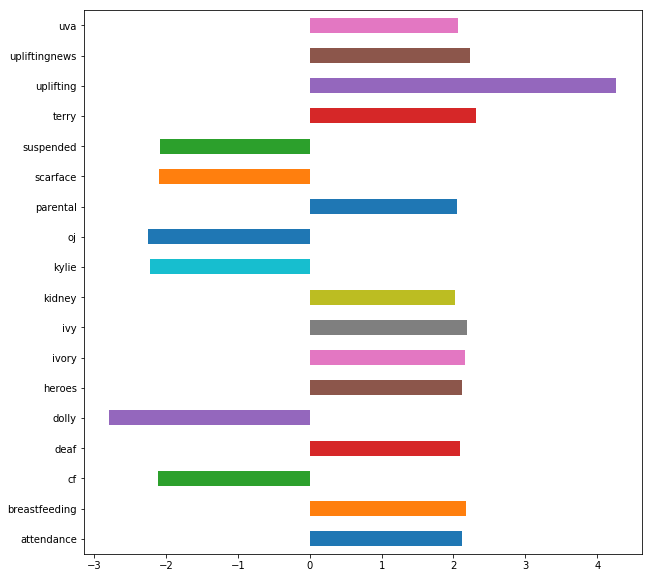

In [57]:
featurenamesc = vectorizerc.get_feature_names()
featsc = pd.DataFrame(lrc.coef_, columns=featurenamesc)
featsc.loc[0,featsc.iloc[0,:].abs() >2].plot(kind='barh', figsize=(10,10));

The graph above is a visual representation of words that have positive (right side) and negative (left side) correlation with comments in r/uplifting news. Only words with an absolute value correlation coefficient of 2 or greater are shown. 

In [58]:
get_subreddit_counts_for_word('prenup', df = comments, column='comments', print_value=True) #Had to change df because the preset is for titles

Number of Uplifting News commentss including "prenup" : 29
Number of News commentss including "prenup" : 1


It is hard to say if having a prenup is right or wrong because every relationship have different circumstances- cultural, political, ethical, etc. The two sides just have to make sure it isn't done on distrust.

When I get married, my husband will have to sign a prenup in order to protect the family business. It's now in its fourth generation, and in the event of a divorce, we have to make sure it stays in the family. 

However, when my brother got married and asked his wife for a prenup, she signed it but got pissed at the whole family because of it. This caused a rift between them and the rest of the family. 

I personally don't believe there is anything wrong with a prenup. I think it's smart to protect yourself and others in any situation that may arise. Plan for the best, but prepare for the worst. 

The article says she's Vice President of an Insurance company, and is a PH

The word 'prenup' was probably referenced once in a title in r/upliftingnews, therefore probably why we see it come up more in the number of times in the comments

## Creating Wordcloud For Titles

Below we will create wordclouds to visually see which words are more highly correlated with r/upliftingnews and more negativley correlated with r/uplifting news

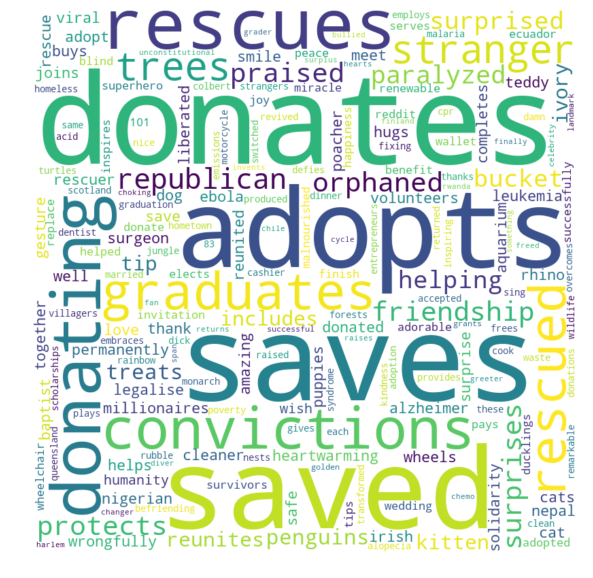

In [62]:
wordclouddf = featst.T
wordclouddf = wordclouddf[wordclouddf[0] >= 0][0].map(lambda x:  x**2)
wordclouddict = wordclouddf.to_dict()
wordclouddict['uplifting'] = 0
wordclouddict['upliftingnews'] = 0

wordcloud = WordCloud(width=800, height=800,background_color='white').generate_from_frequencies(wordclouddict)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


## Creating Wordcloud For Comments

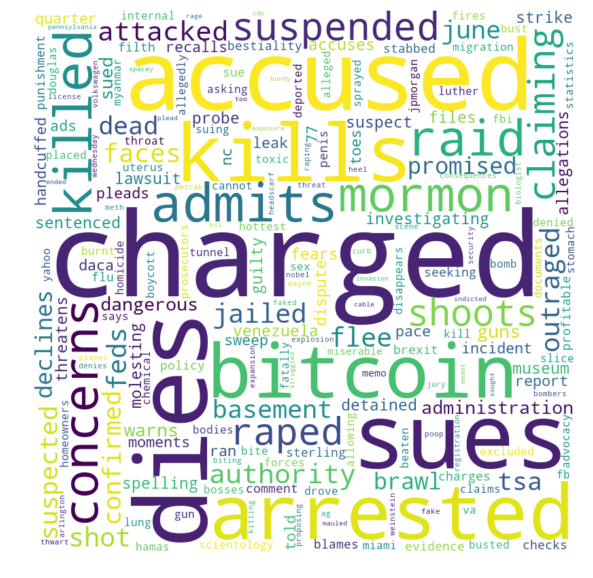

In [63]:
wordclouddf = featst.T
wordclouddf = wordclouddf[wordclouddf[0] <= 0][0].map(lambda x:  x**2)
wordclouddict = wordclouddf.to_dict()
wordclouddict['uplifting'] = 0
wordclouddict['upliftingnews'] = 0

wordcloud = WordCloud(width=800, height=800,background_color='white').generate_from_frequencies(wordclouddict)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

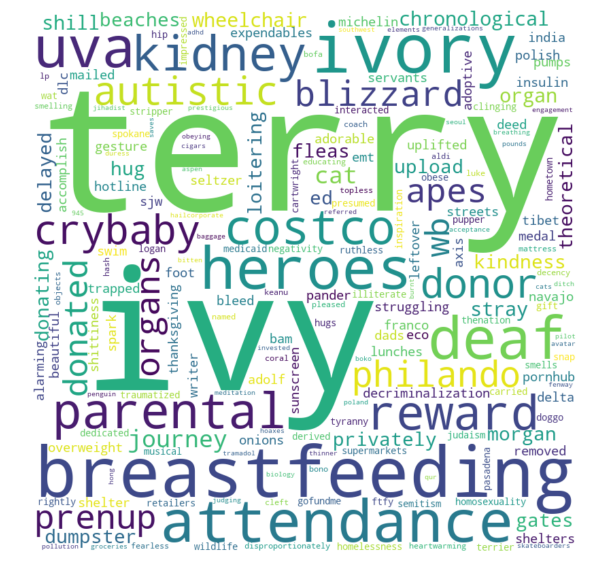

In [59]:
wordclouddf = featsc.T
wordclouddf = wordclouddf[wordclouddf[0] >= 0][0].map(lambda x:  x**2)
wordclouddict = wordclouddf.to_dict()
wordclouddict['uplifting'] = 0
wordclouddict['upliftingnews'] = 0

wordcloud = WordCloud(width=800, height=800,background_color='white').generate_from_frequencies(wordclouddict)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

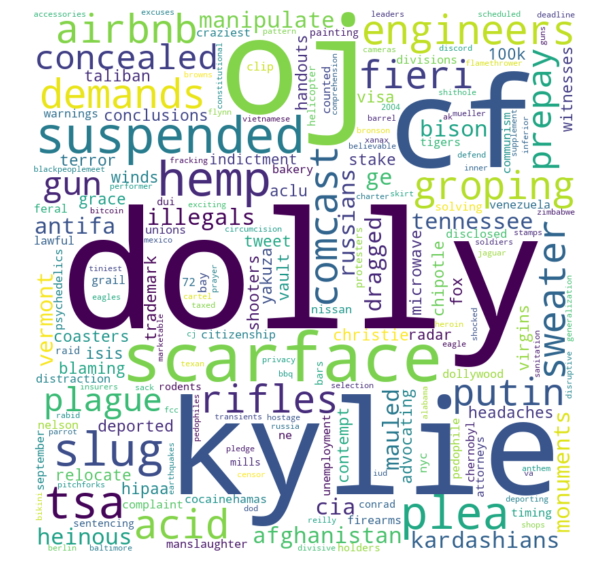

In [61]:
wordclouddf = featsc.T
wordclouddf = wordclouddf[wordclouddf[0] <= 0][0].map(lambda x:  x**2)
wordclouddict = wordclouddf.to_dict()
wordclouddict['uplifting'] = 0
wordclouddict['upliftingnews'] = 0

wordcloud = WordCloud(width=800, height=800,background_color='white').generate_from_frequencies(wordclouddict)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

If we compare the word clouds from titles to the wordclouds from comments, we can see that the wordclouds from titles do follow a pattern that we would be able to distinguish which one is uplifting and which one is not. However, with the wordcloud made from the comments, it is much harder to categorize positive vs negative r/upliftingnews word correlations

---

## Conclusions and Recomendations
This project helped me further undestand the data science process, from finding a problem statment, gathering data, modeling to visualizations. I chose these two subreddits because as a frequent data user, I find myself browsing through r/upliftingnews quite often and thought it would be a great idea to be able to create a model that could potentially find any news story and be able to tell whether it is uplifting or not. Although my model is far from perfect I believe it does quite well. Because it focuses on a few key words it might have trouble with titles that have both both higly and negativley correlated words within the title. 

As expexted, our model worked better with titles than comments, since people in the comment  tend to post their opinions, reference other articles or anecdotes that deviate from the acual topic of the post. As a recomendation to anyone doing any project similar to this, I would suggest taking only the titles for this very same reason. 

Because r/news and r/upliftingnews are not utually exclusive (in fact r/upliftingnews is a subset of r/news), our false positives are not actually bad. It means that the model is 'mistaking' someting in r/upliftingnews as r/news which is not wrong. I believe it would have been better to maybe find another subreddit such as r/horriblydepressing or r/sadnews and be able to create a model that categorizes news titles as sad, neutral or uplifting.